# Multivariable Regression 

Running a multivariable regression based on [2013 crime data in New York State](https://ucr.fbi.gov/crime-in-the-u.s/2013/crime-in-the-u.s.-2013/tables/table-8/table-8-state-cuts/table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls) from the FBI: UCR.

The target variable will be `PropertyCrime`.


In [38]:
import math
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
%matplotlib inline

# Supressing an annoying, harmless error.
warnings.filterwarnings(
    action='ignore',
    module='scipy',
    message='^internal gelsd')

In [2]:
fbi = pd.read_excel("table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls", 
                    skiprows=[0,1,2,3], skipfooter=3)

In [3]:
fbi.head()

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
0,Adams Village,1861,0,0,NaN,0,0,0,12,2,10,0,0.0
1,Addison Town and Village,2577,3,0,NaN,0,0,3,24,3,20,1,0.0
2,Akron Village,2846,3,0,NaN,0,0,3,16,1,15,0,0.0
3,Albany,97956,791,8,NaN,30,227,526,4090,705,3243,142,NaN
4,Albion Village,6388,23,0,NaN,3,4,16,223,53,165,5,NaN


In [4]:
fbi.describe()

,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
count,3.480000e+02,348.000000,348.000000,0.0,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,187.000000
mean,4.003763e+04,201.594828,1.566092,NaN,5.864943,72.902299,121.261494,792.606322,119.683908,637.017241,35.905172,1.871658
std,4.500374e+05,2815.268504,18.303673,NaN,60.425452,1031.032873,1706.131730,7659.724746,924.948789,6346.054451,403.423826,10.693411
min,5.260000e+02,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.003000e+03,2.000000,0.000000,NaN,0.000000,0.000000,1.000000,40.500000,6.000000,31.000000,0.000000,0.000000
50%,7.233500e+03,6.000000,0.000000,NaN,0.000000,1.000000,4.000000,112.500000,17.500000,94.000000,2.000000,0.000000
75%,1.842750e+04,22.000000,0.000000,NaN,2.000000,5.000000,14.000000,341.000000,51.250000,287.250000,7.000000,1.000000
max,8.396126e+06,52384.000000,335.000000,NaN,1112.000000,19170.000000,31767.000000,141971.000000,16606.000000,117931.000000,7434.000000,132.000000


In [5]:
# Dropping Rape Revised Definition because it contains no information
fbi = fbi.drop(['Rape\n(revised\ndefinition)1'], axis=1)

In [6]:
# Renaming to remove line breaks, parentheticals, and footnotes
fbi.columns = ['City', 'Population', 'ViolentCrime', 'MurderManslaughter', 'Rape', 'Robbery', 
               'AggAssault', 'PropertyCrime', 'Burglary', 'LarcenyTheft', 'MotorVehicleTheft', 'Arson']

In [7]:
fbi = fbi.fillna(0)

In [8]:
fbi['Arson'] = fbi['Arson'].astype('int32')

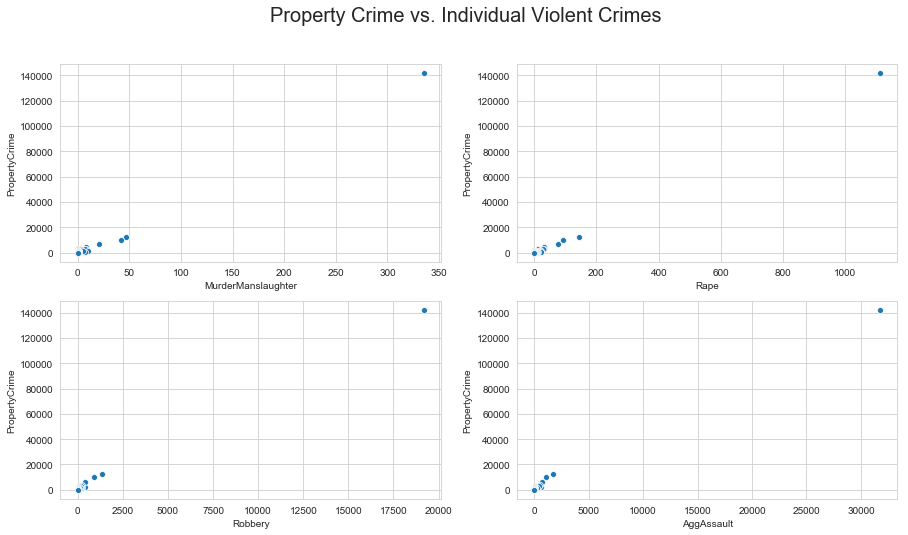

In [68]:
# Full dataset
sns.set_style('whitegrid')

plt.figure(figsize=(15,8))
plt.suptitle('Property Crime vs. Individual Violent Crimes', size=20)

plt.subplot(2,2,1)
sns.scatterplot(data=fbi, y='PropertyCrime', x='MurderManslaughter')

plt.subplot(2,2,2)
sns.scatterplot(data=fbi, y='PropertyCrime', x='Rape')

plt.subplot(2,2,3)
sns.scatterplot(data=fbi, y='PropertyCrime', x='Robbery')

plt.subplot(2,2,4)
sns.scatterplot(data=fbi, y='PropertyCrime', x='AggAssault')
plt.show()

New York City, and potentially some of the other large cities are strong outliers.  This are obcuring the analysis.

In [9]:
# The large cities are going to massively obscure the data analysis to come,
# creating a DF without the top 5 largest cities

fbi = fbi.sort_values('Population', ascending=False)
fbi_smallcities = fbi.iloc[5:]
fbi_largecities = fbi.iloc[:5]

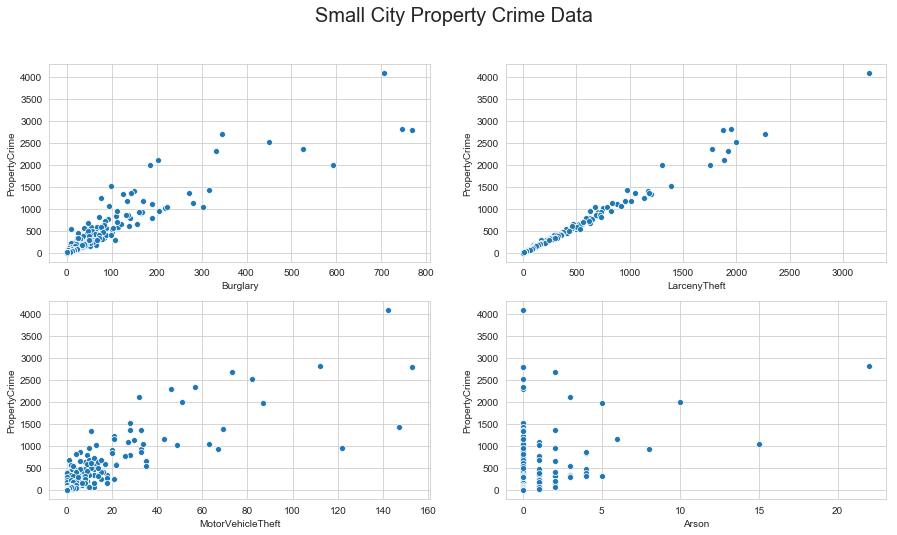

In [10]:
# Small city data
sns.set_style('whitegrid')

plt.figure(figsize=(15,8))
plt.suptitle('Small City Property Crime Data', size=20)

plt.subplot(2,2,1)
sns.scatterplot(data=fbi_smallcities, y='PropertyCrime', x='Burglary')

plt.subplot(2,2,2)
sns.scatterplot(data=fbi_smallcities, y='PropertyCrime', x='LarcenyTheft')

plt.subplot(2,2,3)
sns.scatterplot(data=fbi_smallcities, y='PropertyCrime', x='MotorVehicleTheft')

plt.subplot(2,2,4)
sns.scatterplot(data=fbi_smallcities, y='PropertyCrime', x='Arson')
plt.show()

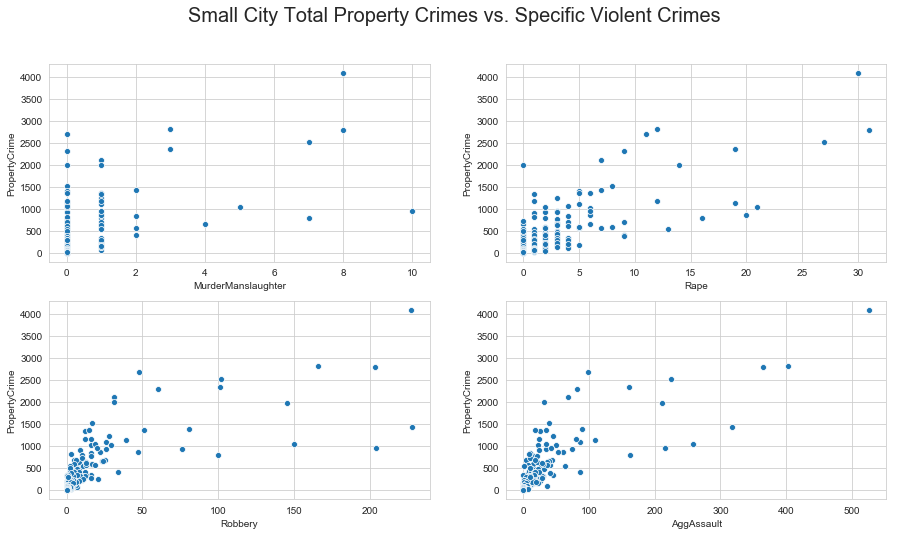

In [11]:
# Small city property crime vs. specific violent crimes

plt.figure(figsize=(15,8))
plt.suptitle('Small City Total Property Crimes vs. Specific Violent Crimes', size=20)

plt.subplot(2,2,1)
sns.scatterplot(data=fbi_smallcities, y='PropertyCrime', x='MurderManslaughter')

plt.subplot(2,2,2)
sns.scatterplot(data=fbi_smallcities, y='PropertyCrime', x='Rape')

plt.subplot(2,2,3)
sns.scatterplot(data=fbi_smallcities, y='PropertyCrime', x='Robbery')

plt.subplot(2,2,4)
sns.scatterplot(data=fbi_smallcities, y='PropertyCrime', x='AggAssault')
plt.show()

Robbery and AggAssault have the best behaved relationship with PropertyCrimes, but they essentially have the same trend.  Because of this, I will only use one of them in the model.  Also of note is that the they do not have a linear correlation with PropertyCrime - one will have to be created via a transformation.

MurderManslaughter could potentially be One Hot Encoded.

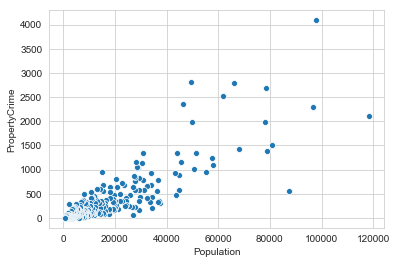

In [12]:
# Total property crimes vs. population for small cities
sns.scatterplot(data=fbi_smallcities, y='PropertyCrime', x='Population')
plt.show()

There is a slightly non-linear trend with population, perhaps a square?  Will attempt to use a transformed population variable.

In [13]:
fbi_smallcities['Robbery_sqrt'] = fbi_smallcities['Robbery'].apply(lambda x: math.sqrt(x))

/Users/mkfrancsis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [14]:
fbi_smallcities['Population_sq'] = fbi_smallcities['Population'] ** 2

/Users/mkfrancsis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


/Users/mkfrancsis/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


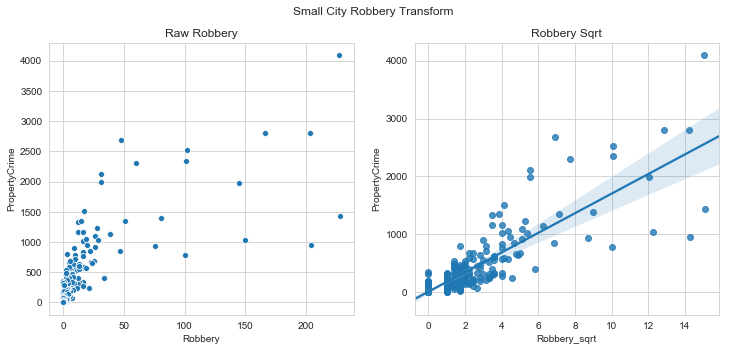

In [24]:
plt.figure(figsize=(12,5))
plt.suptitle('Small City Robbery Transform')

plt.subplot(1,2,1)
sns.scatterplot(data=fbi_smallcities, y='PropertyCrime', x='Robbery')
plt.title('Raw Robbery')

plt.subplot(1,2,2)
sns.regplot(data=fbi_smallcities, y='PropertyCrime', x='Robbery_sqrt')
plt.title('Robbery Sqrt')
plt.show()

The square root of Robbery looks perfect

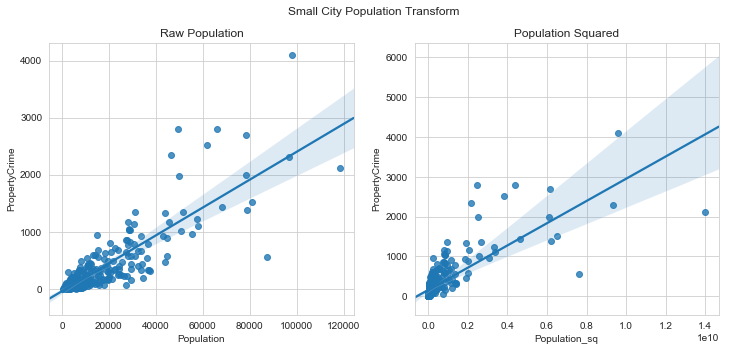

In [25]:
plt.figure(figsize=(12,5))
plt.suptitle('Small City Population Transform')

plt.subplot(1,2,1)
sns.regplot(data=fbi_smallcities, y='PropertyCrime', x='Population')
plt.title('Raw Population')

plt.subplot(1,2,2)
sns.regplot(data=fbi_smallcities, y='PropertyCrime', x='Population_sq')
plt.title('Population Squared')
plt.show()

I think the raw population has a more even distribution than the squared version.


I'll re-compute these variables for the full dataset and redisplay.

In [20]:
fbi['Robbery_sqrt'] = fbi['Robbery'].apply(lambda x: math.sqrt(x))
fbi['Population_sq'] = fbi['Population'] ** 2

/Users/mkfrancsis/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


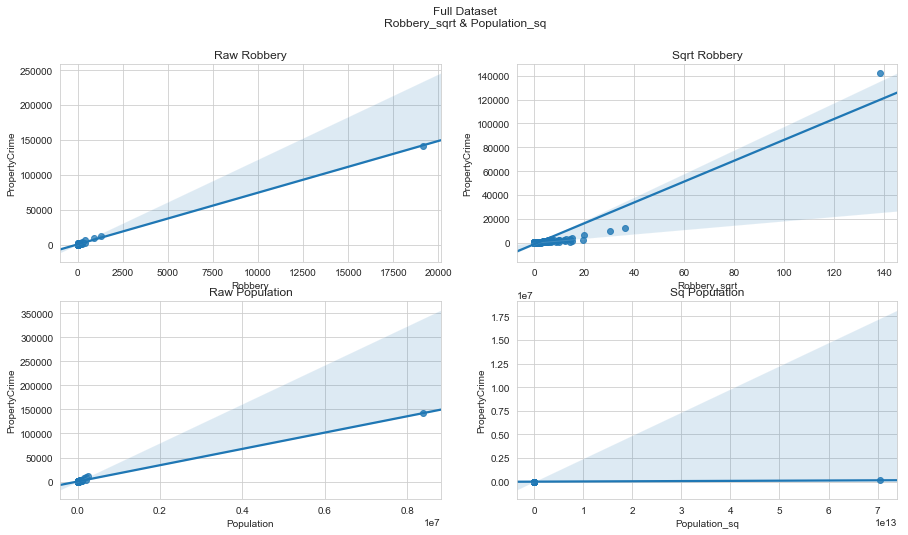

In [23]:
plt.figure(figsize=(15,8))
plt.suptitle('Full Dataset\nRobbery_sqrt & Population_sq')

plt.subplot(2,2,1)
sns.regplot(data=fbi, x='Robbery', y='PropertyCrime')
plt.title('Raw Robbery')

plt.subplot(2,2,2)
sns.regplot(data=fbi, x='Robbery_sqrt', y='PropertyCrime')
plt.title('Sqrt Robbery')

plt.subplot(2,2,3)
sns.regplot(data=fbi, x='Population', y='PropertyCrime')
plt.title('Raw Population')

plt.subplot(2,2,4)
sns.regplot(data=fbi, x='Population_sq', y='PropertyCrime')
plt.title('Sq Population')
plt.tight_layout
plt.show()

Annoyingly, NYC is a massive outlier, but it contains a majority of the data too.  I'll run these variables on just the large cities and see if those have a trend that isn't obliterated by NYC.

In [26]:
fbi_largecities['Robbery_sqrt'] = fbi_largecities['Robbery'].apply(lambda x: math.sqrt(x))
fbi_largecities['Population_sq'] = fbi_largecities['Population'] ** 2

/Users/mkfrancsis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/mkfrancsis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


/Users/mkfrancsis/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


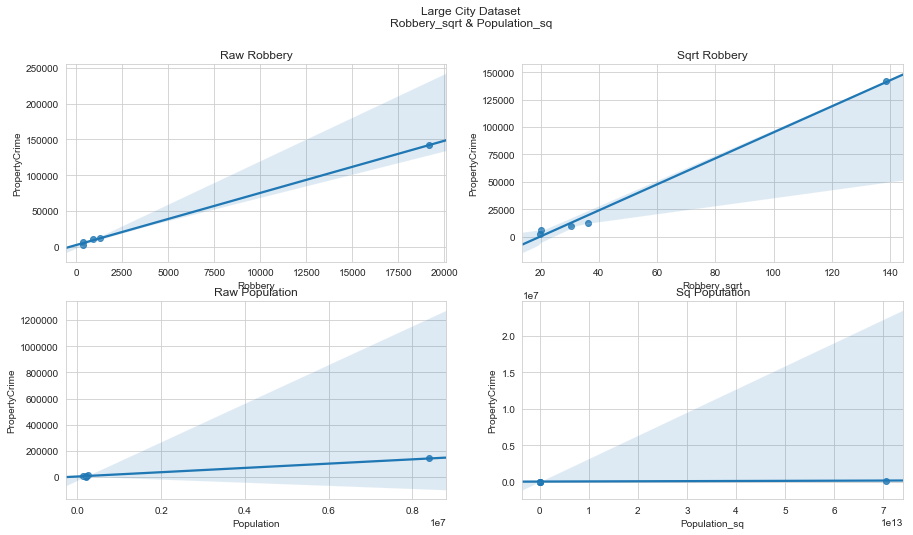

In [73]:
plt.figure(figsize=(15,8))
plt.suptitle('Large City Dataset\nRobbery_sqrt & Population_sq')

plt.subplot(2,2,1)
sns.regplot(data=fbi_largecities, x='Robbery', y='PropertyCrime')
plt.title('Raw Robbery')

plt.subplot(2,2,2)
sns.regplot(data=fbi_largecities, x='Robbery_sqrt', y='PropertyCrime')
plt.title('Sqrt Robbery')

plt.subplot(2,2,3)
sns.regplot(data=fbi_largecities, x='Population', y='PropertyCrime')
plt.title('Raw Population')

plt.subplot(2,2,4)
sns.regplot(data=fbi_largecities, x='Population_sq', y='PropertyCrime')
plt.title('Sq Population')
plt.tight_layout
plt.show()

Still not great, but it's better!  I will One Hot Enocde the large cities to try to capture this outlier-ness.

In [33]:
def large_cities(x):
    # Function to One Hot Encode large cities
    
    if x > 120000:
        return 1
    else:
        return 0

In [34]:
# One Hot Encoding large cities

fbi['LargeCity'] = fbi['Population'].apply(large_cities)

# Initial model

$$PropertyCrime = \alpha + LargeCity + \beta_1Population + \beta_2RobberySqrt$$

In [53]:
# Instatiating the initial model

X = fbi[['LargeCity', 'Population', 'Robbery_sqrt']]
y = fbi['PropertyCrime']

X_train, X_test, y_train, y_test = train_test_split(X, y)

regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)

print('Coefficients: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)
print('R-squared: \n', r2_score(y_test, y_pred))


Coefficients: 
 [1.21199226e+03 1.50807186e-02 1.02495932e+02]
Intercept: 
 -80.722981920866
R-squared: 
 0.8966557587812869


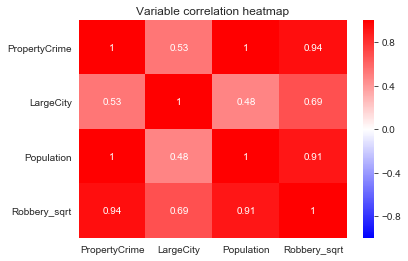

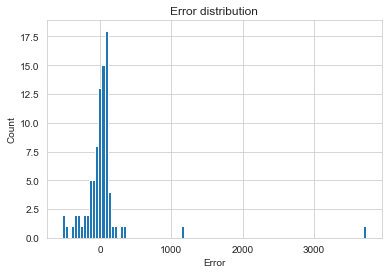

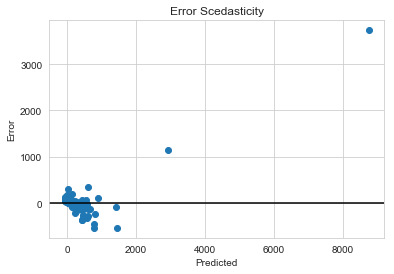

In [83]:
# Analyzing model results

initial_model = fbi.loc[:, ['PropertyCrime', 'LargeCity', 'Population', 'Robbery_sqrt']]

# Variable correlation
sns.heatmap(initial_model.corr(), center=0, vmin=-1, vmax=1, cmap='bwr', annot=True)
plt.title('Variable correlation heatmap')
plt.show()

# Error distribution
plt.hist((y_test - y_pred), bins=100)
plt.title('Error distribution')
plt.xlabel('Error')
plt.ylabel('Count')
plt.show()

# Error scedasticity
plt.scatter(y_pred, (y_test-y_pred))
plt.axhline(0, color='k')
plt.title('Error Scedasticity')
plt.xlabel('Predicted')
plt.ylabel('Error')
plt.show()

## Model issues

Multicollinearity! All the variables are strongly correlated with one another. `Population` and `LargeCity` should be describing the exact same trend.  

**I don't know how to deal with this except to drop everything except population**

Error scedasticity.  There is not a uniform distribution of residuals.  The model is underpredicting the low cases and overpredicting the moderate cases.

**I think this is likely caused by the large city outliers affecting the intercept**